In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Code/')
import adaprobe
import imageio as io
import time
from importlib import reload


Bad key "text.kerning_factor" on line 4 in
C:\Users\Marcus\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
dat = np.load('../Data/npy/201118_cell1_A.npy', allow_pickle=True).item()
img = io.imread('../Data/tiff/201118_cell1_merge2.tif')

In [3]:
cell_locs = dat['cell_locs']
order = dat['stim_order']
stimuli = dat['stimuli']
targets = dat['targets']
responses = dat['responses']

In [4]:
L_all = stimuli[:, :3]
I_all = stimuli[:, -1]

y_all = np.trapz(responses, axis=1)
stim_locs = L_all[L_all[:, -1] == 0][:, :2]
xmin = 194
xmax = 319

num_trials = len(L_all)

In [5]:
# centroids_withz = np.array([
#     [202, 296, 25],
#     [200, 260, None],
#     [225, 282, 25],
#     [241, 309, -25],
#     [255, 290, None],
#     [235, 268, None],
#     [226, 245, -50],
#     [242, 245, None],
#     [258, 235, 25],
#     [284, 252, -50],
#     [311, 252, None],
#     [300, 286, None],
#     [192, 215, -75],
#     [325, 292, None]
# ])

depths = np.array([-75, -50, -25, 0, 25])
ndepths = len(depths)

# centroids_withz[centroids_withz[:, -1] == None, -1] = np.random.choice(depths, len(centroids_withz[centroids_withz[:, -1] == None]))
# cell_locs = centroids_withz.astype(float)

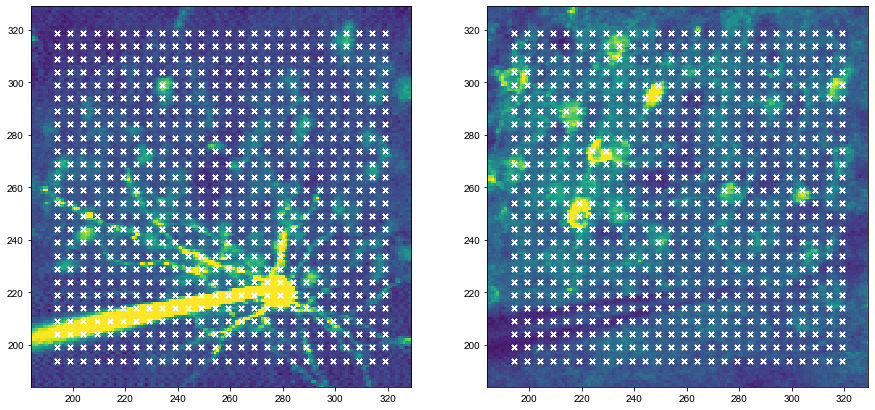

In [6]:
plt.figure(figsize=(15, 7.5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img[:, :, i])
    plt.scatter(stim_locs[:, 0], stim_locs[:, 1], 20, marker='x', color='white')
    plt.xlim([xmin - 10, xmax + 10])
    plt.ylim([xmin - 10, xmax + 10])
plt.show()

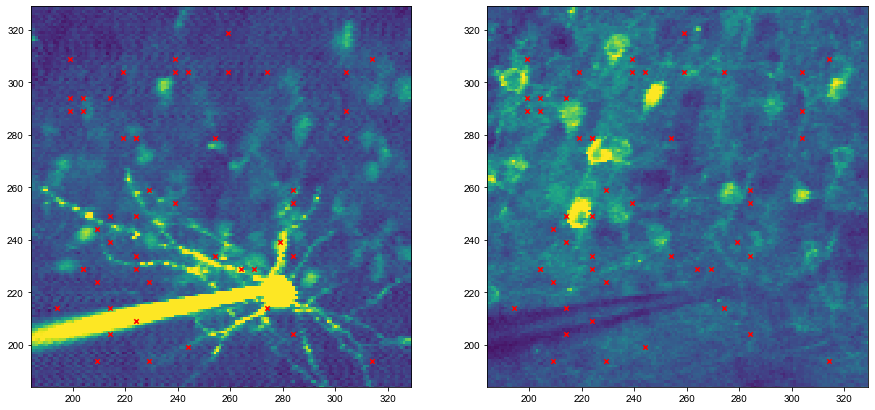

In [7]:
plt.figure(figsize=(15, 7.5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img[:, :, i])
    plt.scatter(cell_locs[:, 0], cell_locs[:, 1], 20, marker='x', color='red')
    plt.xlim([xmin - 10, xmax + 10])
    plt.ylim([xmin - 10, xmax + 10])
plt.show()

In [8]:
test_trials = np.random.choice(np.arange(num_trials), int(0.1 * num_trials))
train_trials = np.setdiff1d(np.arange(num_trials), test_trials)

L, L_test = L_all[train_trials], L_all[test_trials]
I, I_test = I_all[train_trials], I_all[test_trials]

y, y_test = y_all[train_trials], y_all[test_trials]

In [9]:
# cell_locs

In [59]:
N = len(cell_locs)

priors = {
    'alpha': 0.5 * np.ones(N),
    'omega': 1e-3 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 1e1 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[1e-1 * np.ones(N), 1e1 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e1]]) for _ in range(N)])
}

fit_options = {
    'iters': 10,
    'newton_steps': 10,
    'lam_update': 'monte-carlo',
    'verbose': False,
    'init_t': 1e1,
    't_loops': 5,
    't_mult': 15,
    'interp': 0.5,
    'focus_radius': 30
}

model = adaprobe.Model(cell_locs, priors=priors)

In [60]:
K = len(L)
N = len(cell_locs)

curr_trials = K

mu_hist = np.zeros((curr_trials, N))
alpha_hist = np.zeros((curr_trials, N))
sigma_hist = np.zeros((curr_trials, N))
phi_0_hist = np.zeros((curr_trials, N))
phi_1_hist = np.zeros((curr_trials, N))

In [61]:
t1 = time.time()
for k in range(curr_trials):
    print('trial %i/%i'%(k + 1, K), end='\r')
    model.update(y[k], (L[k], I[k]), fit_options=fit_options, method='cavi_online_spike_and_slab')
    mu_hist[k] = model.state['mu']
    phi_0_hist[k] = model.state['phi_map'][:, 0]
    phi_1_hist[k] = model.state['phi_map'][:, 1]
    alpha_hist[k] = model.state['alpha']
    sigma_hist[k] = model.state['shape']/model.state['rate']
t2 = time.time()
print('elapsed time %.2f'%(t2 - t1))

elapsed time 192.72


In [62]:
mu, beta, alpha, phi_0, phi_1, sigma = model.state['mu'], model.state['beta'], model.state['alpha'], model.state['phi_map'][:, 0], model.state['phi_map'][:, 1], sigma_hist[-1]

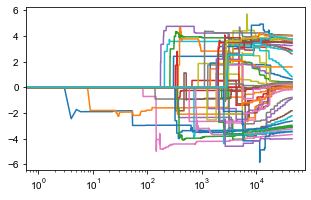

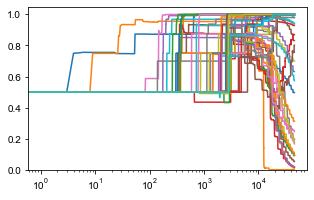

In [63]:
plt.figure(figsize=(5, 3))
plt.plot(mu_hist)
plt.xscale('log')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(alpha_hist)
plt.ylim([0, 1.05])
plt.xscale('log')
plt.show()

In [64]:
model.state['mu']

array([-3.07964614, -0.11997305, -2.95783486,  2.89036211,  3.25694353,
       -1.82394914, -3.67538292, -0.78879839,  0.13429063,  2.82197427,
        0.63697874,  1.58961144,  3.77332666,  0.20438231, -0.89304296,
        0.43012637,  0.05573543,  2.60643009,  3.70265479, -2.2080234 ,
       -2.62603068,  0.13716963, -3.1043923 ,  0.04640904,  0.03155705,
        0.10487537, -3.24474894,  4.00262549,  0.16575246,  0.82860119,
        4.05049386,  4.02051012,  0.38899095,  3.71308421,  0.26886046,
        0.19468576, -0.17957114,  3.52855741,  0.15610921, -3.41789736,
       -3.45370791,  0.03102248, -3.06609407,  3.49712049, -4.00794224,
        3.43601839,  0.24905214,  0.36215099,  3.7290527 ,  3.74127884])

In [65]:
model.state['beta']

array([0.22116193, 0.14069953, 0.06824975, 1.08041755, 0.05331059,
       0.57590712, 0.03623535, 0.60060071, 0.40962097, 0.19094757,
       1.80758518, 0.13365013, 0.04917126, 0.1016306 , 0.74623783,
       0.0742013 , 0.44764318, 0.98069338, 0.16832118, 0.77099701,
       0.03926024, 0.65667556, 0.0294293 , 0.6422865 , 0.46410422,
       0.47379328, 0.03267684, 1.10485652, 0.40012205, 1.17613226,
       0.43702794, 0.0541397 , 0.43479526, 0.13327296, 0.4930232 ,
       0.10097035, 0.32441594, 0.0449876 , 0.22749585, 0.08216789,
       0.13316877, 0.40751567, 0.04155808, 0.20216989, 0.52762814,
       0.2822756 , 0.32289232, 0.06155238, 0.10226749, 0.18723375])

In [66]:
model.state['alpha']

array([9.96554112e-01, 1.14049960e-02, 9.99872185e-01, 9.28868108e-01,
       9.99887855e-01, 8.31631853e-01, 9.99891236e-01, 1.98358889e-01,
       6.99786258e-01, 9.82017477e-01, 4.96629341e-01, 1.23487213e-06,
       9.99898682e-01, 8.69621801e-01, 6.32188760e-01, 9.99823043e-01,
       1.92683534e-01, 9.40086508e-01, 9.99268454e-01, 9.43195799e-01,
       9.99930634e-01, 3.12041442e-01, 9.99934140e-01, 1.72805767e-02,
       9.08502137e-02, 5.31218452e-02, 9.99954496e-01, 9.78604048e-01,
       9.59185269e-02, 5.73628090e-01, 9.98902715e-01, 9.99982894e-01,
       9.47121777e-02, 9.99969230e-01, 1.69178661e-02, 8.01406042e-01,
       1.66657472e-01, 9.99979469e-01, 1.80581658e-01, 9.99922821e-01,
       9.99931812e-01, 9.53277218e-02, 9.99986126e-01, 9.99042325e-01,
       9.98513036e-01, 9.96229379e-01, 2.45912510e-01, 9.99913481e-01,
       9.99961286e-01, 9.99997410e-01])

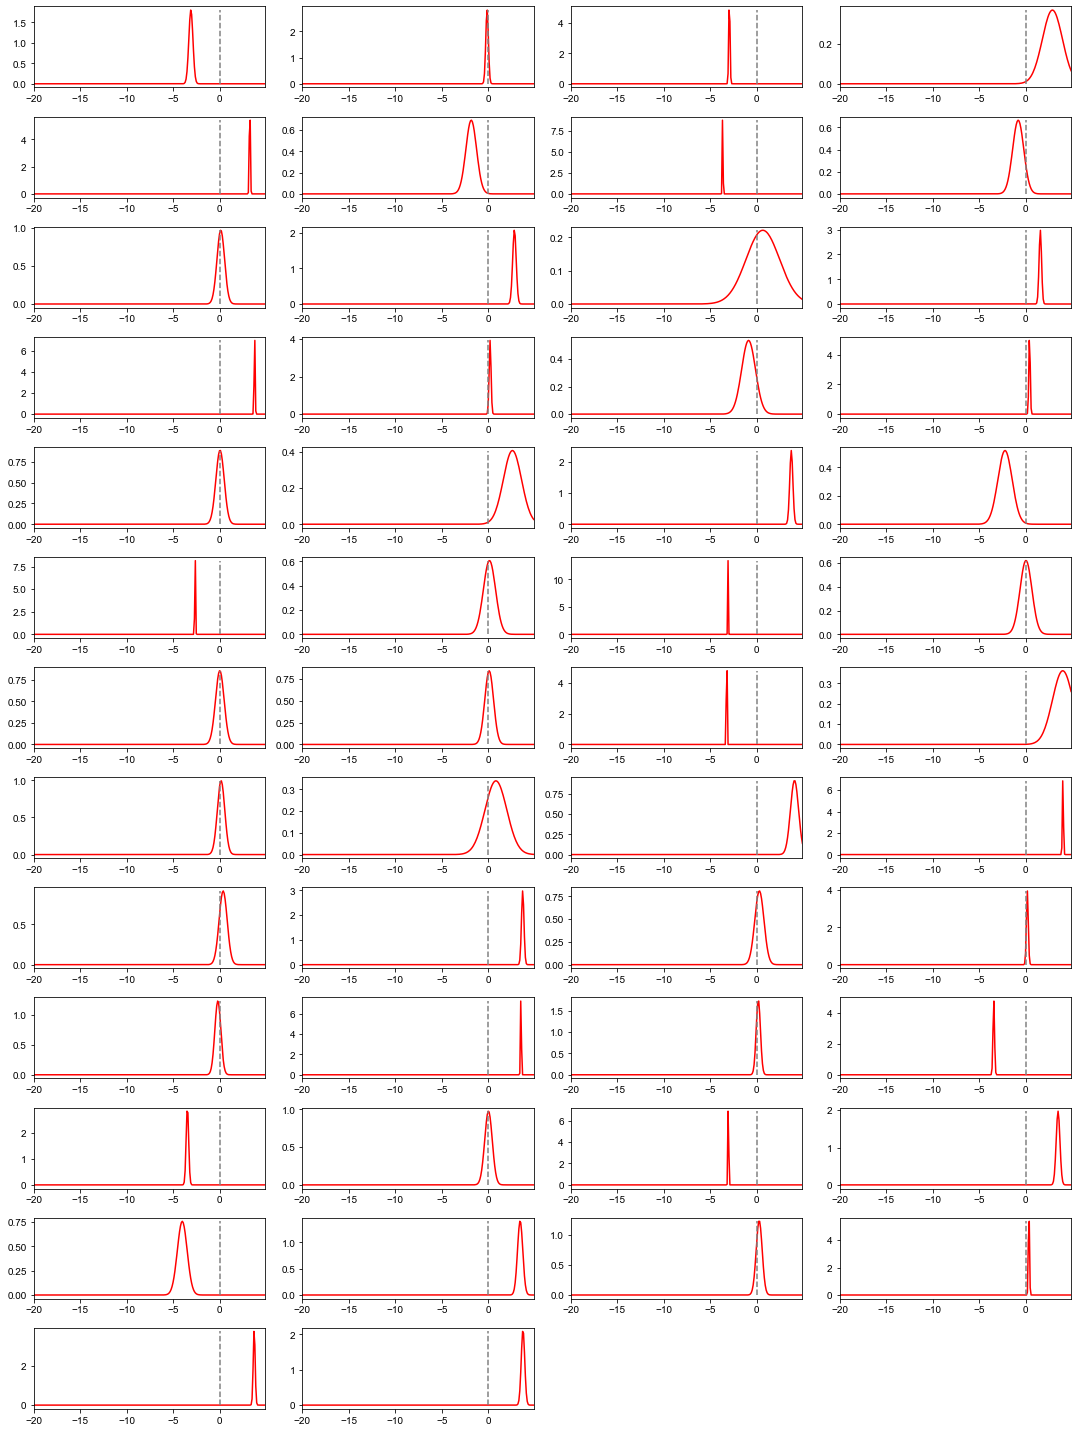

[0.997 0.011 1.    0.929 1.    0.832 1.    0.198 0.7   0.982 0.497 0.
 1.    0.87  0.632 1.    0.193 0.94  0.999 0.943 1.    0.312 1.    0.017
 0.091 0.053 1.    0.979 0.096 0.574 0.999 1.    0.095 1.    0.017 0.801
 0.167 1.    0.181 1.    1.    0.095 1.    0.999 0.999 0.996 0.246 1.
 1.    1.   ]


In [67]:
xrange = np.arange(-20, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

plt.figure(figsize=(15, 20))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    post = gaussf(mu[n], beta[n])
    plt.plot(xrange, post, color='r')
    plt.xlim(np.min(xrange), np.max(xrange))
    plt.plot([0, 0], [0, np.max(post)], '--', color='gray')
plt.tight_layout()
plt.show()

print(np.round(alpha, 3))

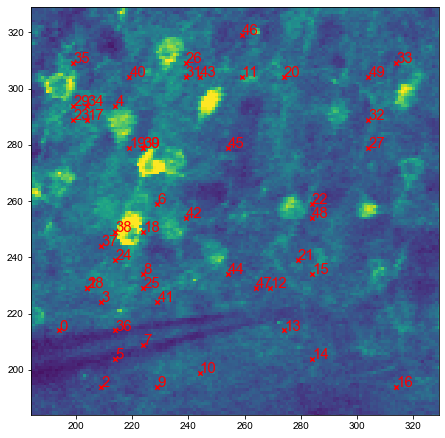

In [68]:
plt.figure(figsize=(15, 7.5))
plt.imshow(img[:, :, 1])
plt.scatter(cell_locs[:, 0], cell_locs[:, 1], 20, marker='x', color='red')
for n in range(N):
    plt.text(cell_locs[n, 0], cell_locs[n, 1], n, fontsize=15, color='red')
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
plt.show()

# Posterior predictive

In [27]:
# cell_locs

In [92]:
num_trials_test = len(y_test)
y_est = np.zeros(num_trials_test)

In [93]:
t1 = time.time()
for i in range(num_trials_test):
    print('trial %i/%i'%(i + 1, num_trials_test), end='\r')
    y_est[i] = np.mean(np.array([adaprobe.experimental_design.posterior_predictive_response(L_test[i], I_test[i], model) for _ in range(50)]))
t2 = time.time()
print('elapsed time %.2f s'%(t2 - t1))

elapsed time 202.45 s


In [95]:
np.corrcoef(y_test, y_est)

array([[1.        , 0.00231099],
       [0.00231099, 1.        ]])

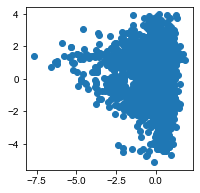

In [94]:
plt.figure(figsize=(3, 3))
plt.scatter(y_test, y_est)
plt.show()

In [31]:
two_d_locs = np.unique(L_all[:, :2])

In [32]:
two_d_locs
nlocs = len(two_d_locs)

In [42]:
reload(adaprobe.experimental_design)

<module 'adaprobe.experimental_design' from '../Code\\adaprobe\\experimental_design.py'>

In [69]:
gridx, gridy, _, _ = adaprobe.simulation._generate_grid(cell_locs, 10)
grid = np.c_[gridx.flatten(), gridy.flatten()]

In [87]:
%time est_ppm = adaprobe.experimental_design.posterior_predictive_map_on_plane(grid, plane=-75, power=70, model=model, n_samples=50)

Wall time: 2.17 s


In [88]:
ngridx = len(np.unique(grid[:, 0]))
ngridy = len(np.unique(grid[:, 1]))

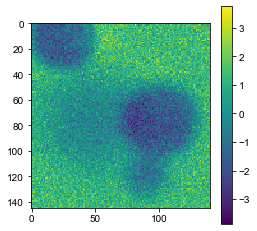

In [90]:
plt.figure(figsize=(4, 4))
plt.imshow(est_ppm.reshape([ngridy, ngridx]), origin='upper')
plt.colorbar()
plt.show()

In [91]:
np.corrcoef(y_test, y_est)

array([[1.        , 0.02234614],
       [0.02234614, 1.        ]])

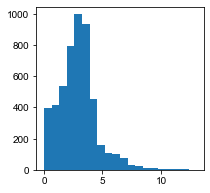

In [55]:
plt.figure(figsize=(3, 3))
plt.hist(np.abs(y_test - y_est), 20)
plt.show()

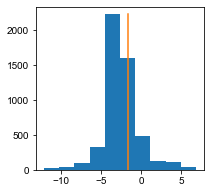

In [56]:
plt.figure(figsize=(3, 3))
hist = plt.hist(y_est)
plt.plot([y_test[0], y_test[0]], [0, np.max(hist[0])], 20)
plt.show()